# Taller 2: Regresión Múltiple - Pruebas de Hipótesis e Intervalos

## Descripción
En este taller exploraremos cómo realizar inferencia estadística en modelos de regresión múltiple, enfocándonos en la construcción de pruebas de hipótesis e intervalos de confianza para los coeficientes del modelo. Aprenderemos a implementar desde cero los estadísticos t y F, y a interpretar sus resultados en diferentes escenarios prácticos.

## Objetivos de Aprendizaje
- Formular pruebas de hipótesis sobre coeficientes individuales y conjuntos de coeficientes
- Calcular e interpretar intervalos de confianza para los parámetros del modelo
- Aplicar t-test y F-test en el contexto de regresión múltiple
- Implementar computacionalmente las metodologías de inferencia estadística

## Prerrequisitos
- Haber completado el Taller 0 (Modelo Centrado) y el Taller 1 (Modelo Normal)
- Conocimientos básicos de álgebra lineal y estadística inferencial
- Familiaridad con Python y bibliotecas científicas (NumPy, SciPy, Matplotlib)



In [1]:
# Importación de bibliotecas necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import linalg
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Configuraciones de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
sns.set_palette("viridis")

# Para reproducibilidad
np.random.seed(123)

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas correctamente")


Bibliotecas importadas correctamente


## 1. Fundamentos Teóricos de la Inferencia en Regresión Múltiple

En los talleres anteriores, introdujimos el modelo de regresión lineal múltiple y exploramos los estimadores de mínimos cuadrados ordinarios (OLS) y máxima verosimilitud (MLE) bajo el supuesto de normalidad. Ahora, daremos un paso más y nos centraremos en cómo realizar inferencia estadística sobre los parámetros estimados.

### 1.1 Recordatorio del Modelo Lineal

Recordemos brevemente el modelo de regresión lineal múltiple:

$$y = X\beta + \varepsilon$$

donde:
- $y$ es un vector de $n$ observaciones de la variable dependiente
- $X$ es una matriz de diseño de $n \times (p+1)$ (incluyendo una columna de unos para el intercepto)
- $\beta$ es un vector de $(p+1)$ coeficientes a estimar
- $\varepsilon$ es un vector de $n$ términos de error aleatorios

Bajo los supuestos clásicos:
1. Linealidad: $E[y|X] = X\beta$
2. Independencia: los errores $\varepsilon_i$ son independientes entre sí
3. Homocedasticidad: $Var(\varepsilon_i) = \sigma^2$ para todo $i$
4. Normalidad: $\varepsilon \sim N(0, \sigma^2 I_n)$

El estimador de mínimos cuadrados ordinarios es:

$$\hat{\beta} = (X'X)^{-1}X'y$$

Y su matriz de covarianza:

$$Var(\hat{\beta}) = \sigma^2 (X'X)^{-1}$$

donde $\sigma^2$ es la varianza del error, que podemos estimar como:

$$\hat{\sigma}^2 = \frac{RSS}{n-p-1} = \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{n-p-1}$$

Aquí, $RSS$ representa la suma de cuadrados de los residuos y $(n-p-1)$ son los grados de libertad del modelo.


### 1.2 Inferencia sobre Coeficientes Individuales: El Estadístico t

Una vez que hemos estimado los coeficientes $\hat{\beta}$, nos interesa evaluar si estos son estadísticamente significativos. Para un coeficiente individual $\beta_j$, la hipótesis nula típica es:

$$H_0: \beta_j = 0$$

versus la alternativa:

$$H_1: \beta_j \neq 0$$

Bajo los supuestos del modelo lineal clásico, el estadístico t para probar esta hipótesis es:

$$t_j = \frac{\hat{\beta}_j - 0}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j}{\sqrt{\hat{\sigma}^2 \cdot [( X'X)^{-1}]_{jj}}}$$

donde $[( X'X)^{-1}]_{jj}$ es el elemento diagonal $j$-ésimo de la matriz $(X'X)^{-1}$.

Bajo $H_0$, este estadístico sigue una distribución t de Student con $(n-p-1)$ grados de libertad. Para un nivel de significación $\alpha$, rechazamos $H_0$ si:

$$|t_j| > t_{n-p-1, \alpha/2}$$

donde $t_{n-p-1, \alpha/2}$ es el valor crítico de la distribución t con $(n-p-1)$ grados de libertad.

#### Interpretación del p-valor

El p-valor asociado a un estadístico t observado nos indica la probabilidad de obtener un valor tan extremo (o más) si la hipótesis nula fuera cierta. Matemáticamente:

$$p\text{-valor} = 2 \cdot P(T_{n-p-1} > |t_j|)$$

donde $T_{n-p-1}$ es una variable aleatoria con distribución t de Student con $(n-p-1)$ grados de libertad.

Típicamente:
- Si $p\text{-valor} \leq \alpha$, rechazamos $H_0$
- Si $p\text{-valor} > \alpha$, no rechazamos $H_0$


### 1.3 Intervalos de Confianza para Coeficientes

Un intervalo de confianza del $(1-\alpha)\cdot 100\%$ para un coeficiente $\beta_j$ viene dado por:

$$\hat{\beta}_j \pm t_{n-p-1, \alpha/2} \cdot SE(\hat{\beta}_j)$$

Este intervalo tiene la siguiente interpretación: si repitiéramos el muestreo y la estimación muchas veces, el $(1-\alpha)\cdot 100\%$ de los intervalos calculados contendría el verdadero valor del parámetro $\beta_j$.

#### Relación con Pruebas de Hipótesis

Existe una relación directa entre intervalos de confianza y pruebas de hipótesis. En particular, para la hipótesis $H_0: \beta_j = 0$:
- Si el intervalo de confianza de $\beta_j$ no contiene el cero, rechazamos $H_0$
- Si el intervalo de confianza de $\beta_j$ contiene el cero, no rechazamos $H_0$

Esta correspondencia hace que los intervalos de confianza sean una herramienta visual muy útil para evaluar la significancia estadística.


### 1.4 Pruebas de Hipótesis Conjuntas: El Estadístico F

A menudo nos interesa probar hipótesis sobre múltiples coeficientes simultáneamente. Por ejemplo, podríamos querer evaluar si un subconjunto de variables independientes tiene algún efecto en la variable dependiente.

Una hipótesis conjunta típica puede escribirse como:

$$H_0: \beta_{j_1} = \beta_{j_2} = \ldots = \beta_{j_q} = 0$$

o de forma matricial:

$$H_0: R\beta = 0$$

donde $R$ es una matriz de $q \times (p+1)$ que especifica las restricciones lineales.

Para probar esta hipótesis utilizamos el estadístico F:

$$F = \frac{(RSS_R - RSS_{UR}) / q}{RSS_{UR} / (n-p-1)}$$

donde:
- $RSS_R$ es la suma de cuadrados de residuos del modelo restringido (bajo $H_0$)
- $RSS_{UR}$ es la suma de cuadrados de residuos del modelo no restringido
- $q$ es el número de restricciones (coeficientes probados conjuntamente)
- $(n-p-1)$ son los grados de libertad del modelo no restringido

Bajo $H_0$, este estadístico sigue una distribución F con $q$ y $(n-p-1)$ grados de libertad. Rechazamos $H_0$ si:

$$F > F_{q, n-p-1, \alpha}$$

donde $F_{q, n-p-1, \alpha}$ es el valor crítico de la distribución F.

#### Casos Particulares de Pruebas F

1. **Significancia global del modelo**: Probar si todas las variables independientes (excluyendo el intercepto) son conjuntamente significativas:
   $$H_0: \beta_1 = \beta_2 = \ldots = \beta_p = 0$$

   En este caso, el estadístico F se puede calcular como:

   $$F = \frac{ESS/p}{RSS/(n-p-1)}$$

   donde $ESS$ (Error Sum of Squares) es la suma de cuadrados explicada.

2. **Comparación de modelos anidados**: Probar si un conjunto de variables adicionales mejora significativamente el modelo.


### 1.5 Coeficiente de Determinación y Prueba F

El coeficiente de determinación $R^2$ mide la proporción de la varianza total de la variable dependiente que es explicada por el modelo de regresión. Se calcula como:

$$R^2 = 1 - \frac{RSS}{TSS} = \frac{ESS}{TSS}$$

donde:
- $RSS$ es la suma de cuadrados de los residuos: $\sum_{i=1}^n (y_i - \hat{y}_i)^2$
- $TSS$ es la suma total de cuadrados: $\sum_{i=1}^n (y_i - \bar{y})^2$
- $ESS$ es la suma de cuadrados explicada: $\sum_{i=1}^n (\hat{y}_i - \bar{y})^2$

#### Relación con el Estadístico F

Existe una relación directa entre el $R^2$ y el estadístico F para la prueba de significancia global del modelo:

$$F = \frac{R^2/p}{(1-R^2)/(n-p-1)}$$

Esta fórmula muestra que ambas medidas están intrínsecamente relacionadas.

#### $R^2$ Ajustado

Una limitación del $R^2$ es que siempre aumenta al añadir más variables al modelo, incluso si estas no son significativas. El $R^2$ ajustado corrige este problema penalizando por la cantidad de parámetros:

$$R^2_{adj} = 1 - \frac{RSS/(n-p-1)}{TSS/(n-1)} = 1 - \frac{n-1}{n-p-1}(1-R^2)$$

El $R^2_{adj}$ solo aumenta si la adición de una nueva variable reduce suficientemente la RSS en relación con la pérdida de un grado de libertad.


## 2. Implementación Computacional

A continuación, implementaremos las funciones necesarias para realizar inferencia estadística en modelos de regresión lineal múltiple.

### 2.1 Implementación del Modelo de Regresión Lineal

Primero, crearemos una función para ajustar un modelo de regresión lineal utilizando OLS:


In [2]:
def ajustar_ols(X, y):
    """
    Ajusta un modelo de regresión lineal usando mínimos cuadrados ordinarios (OLS).

    Parámetros:
    -----------
    X : array-like
        Matriz de diseño con n observaciones y p+1 variables (incluyendo intercepto).
    y : array-like
        Vector de variable dependiente con n observaciones.

    Retorna:
    --------
    dict
        Diccionario con los resultados del modelo:
        - betas: vector de coeficientes estimados
        - residuos: vector de residuos
        - sigma2: estimación de la varianza del error
        - var_betas: matriz de covarianza de los coeficientes
        - se_betas: errores estándar de los coeficientes
        - X: matriz de diseño (para uso posterior)
        - y: vector de variable dependiente
        - n: número de observaciones
        - p: número de predictores (sin contar intercepto)
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1, 1)

    n, k = X.shape  # n: número de observaciones, k: número de predictores + intercepto
    p = k - 1       # número de predictores (sin contar intercepto)

    # Calcular coeficientes (β̂ = (X'X)^-1 X'y)
    XtX = X.T @ X
    Xty = X.T @ y
    betas = np.linalg.solve(XtX, Xty)

    # Calcular valores ajustados y residuos
    y_pred = X @ betas
    residuos = y - y_pred

    # Estimar la varianza del error (σ²)
    RSS = np.sum(residuos**2)
    sigma2 = RSS / (n - k)

    # Calcular matriz de covarianza de los coeficientes
    var_betas = sigma2 * np.linalg.inv(XtX)

    # Calcular errores estándar de los coeficientes
    se_betas = np.sqrt(np.diag(var_betas)).reshape(-1, 1)

    # Calcular suma total de cuadrados (TSS)
    y_mean = np.mean(y)
    TSS = np.sum((y - y_mean)**2)

    # Calcular suma de cuadrados explicada (ESS)
    ESS = np.sum((y_pred - y_mean)**2)

    # Coeficiente de determinación (R²)
    R2 = ESS / TSS

    # R² ajustado
    R2_adj = 1 - (1 - R2) * ((n - 1) / (n - k))

    return {
        'betas': betas,
        'y_pred': y_pred,
        'residuos': residuos,
        'sigma2': sigma2,
        'var_betas': var_betas,
        'se_betas': se_betas,
        'RSS': RSS,
        'TSS': TSS,
        'ESS': ESS,
        'R2': R2,
        'R2_adj': R2_adj,
        'X': X,
        'y': y,
        'n': n,
        'p': p
    }


In [3]:
### 2.2 Implementación de Pruebas de Hipótesis e Intervalos

def prueba_t(modelo, idx, valor_nulo=0, alpha=0.05):
    """
    Realiza una prueba t para un coeficiente individual.

    Parámetros:
    -----------
    modelo : dict
        Resultados del modelo de regresión.
    idx : int
        Índice del coeficiente a probar (0 para intercepto).
    valor_nulo : float, opcional
        Valor nulo para la hipótesis (por defecto es 0).
    alpha : float, opcional
        Nivel de significación (por defecto es 0.05).

    Retorna:
    --------
    dict
        Diccionario con resultados de la prueba t:
        - t_stat: valor del estadístico t
        - p_value: p-valor de la prueba
        - ci_lower: límite inferior del intervalo de confianza
        - ci_upper: límite superior del intervalo de confianza
        - rechazar_h0: booleano que indica si se rechaza la hipótesis nula
    """
    # Extraer información necesaria del modelo
    betas = modelo['betas']
    se_betas = modelo['se_betas']
    n = modelo['n']
    p = modelo['p']
    gl = n - p - 1  # grados de libertad

    # Calcular estadístico t
    t_stat = (betas[idx] - valor_nulo) / se_betas[idx]

    # Calcular p-valor (dos colas)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), gl))

    # Calcular valor crítico para el nivel alpha
    t_crit = stats.t.ppf(1 - alpha/2, gl)

    # Calcular intervalo de confianza
    ci_lower = betas[idx] - t_crit * se_betas[idx]
    ci_upper = betas[idx] + t_crit * se_betas[idx]

    # Determinar si se rechaza la hipótesis nula
    rechazar_h0 = abs(t_stat) > t_crit

    return {
        't_stat': t_stat[0],
        'p_value': p_value[0],
        'ci_lower': ci_lower[0],
        'ci_upper': ci_upper[0],
        'rechazar_h0': rechazar_h0
    }

def prueba_f_global(modelo, alpha=0.05):
    """
    Realiza una prueba F para la significancia global del modelo.

    Parámetros:
    -----------
    modelo : dict
        Resultados del modelo de regresión.
    alpha : float, opcional
        Nivel de significación (por defecto es 0.05).

    Retorna:
    --------
    dict
        Diccionario con resultados de la prueba F:
        - f_stat: valor del estadístico F
        - p_value: p-valor de la prueba
        - rechazar_h0: booleano que indica si se rechaza la hipótesis nula
    """
    # Extraer información necesaria del modelo
    n = modelo['n']
    p = modelo['p']
    R2 = modelo['R2']

    # Calcular estadístico F
    f_stat = (R2 / p) / ((1 - R2) / (n - p - 1))

    # Calcular p-valor
    p_value = 1 - stats.f.cdf(f_stat, p, n - p - 1)

    # Calcular valor crítico para el nivel alpha
    f_crit = stats.f.ppf(1 - alpha, p, n - p - 1)

    # Determinar si se rechaza la hipótesis nula
    rechazar_h0 = f_stat > f_crit

    return {
        'f_stat': f_stat,
        'p_value': p_value,
        'rechazar_h0': rechazar_h0
    }

def prueba_f_restricciones(modelo_completo, modelo_restringido, q, alpha=0.05):
    """
    Realiza una prueba F para comparar modelos anidados.

    Parámetros:
    -----------
    modelo_completo : dict
        Resultados del modelo completo (no restringido).
    modelo_restringido : dict
        Resultados del modelo restringido.
    q : int
        Número de restricciones (diferencia en número de parámetros).
    alpha : float, opcional
        Nivel de significación (por defecto es 0.05).

    Retorna:
    --------
    dict
        Diccionario con resultados de la prueba F:
        - f_stat: valor del estadístico F
        - p_value: p-valor de la prueba
        - rechazar_h0: booleano que indica si se rechaza la hipótesis nula
    """
    # Extraer información necesaria
    RSS_R = modelo_restringido['RSS']
    RSS_UR = modelo_completo['RSS']
    n = modelo_completo['n']
    p = modelo_completo['p']

    # Calcular estadístico F
    f_stat = ((RSS_R - RSS_UR) / q) / (RSS_UR / (n - p - 1))

    # Calcular p-valor
    p_value = 1 - stats.f.cdf(f_stat, q, n - p - 1)

    # Calcular valor crítico para el nivel alpha
    f_crit = stats.f.ppf(1 - alpha, q, n - p - 1)

    # Determinar si se rechaza la hipótesis nula
    rechazar_h0 = f_stat > f_crit

    return {
        'f_stat': f_stat,
        'p_value': p_value,
        'rechazar_h0': rechazar_h0
    }


In [4]:
def tabla_resultados(modelo, nombres_variables=None, alpha=0.05):
    """
    Genera una tabla de resultados de regresión con coeficientes, errores estándar,
    estadísticos t, p-valores e intervalos de confianza.

    Parámetros:
    -----------
    modelo : dict
        Resultados del modelo de regresión.
    nombres_variables : list, opcional
        Lista con nombres de variables. Si no se proporciona, se generan automáticamente.
    alpha : float, opcional
        Nivel de significación para los intervalos de confianza.

    Retorna:
    --------
    DataFrame
        Tabla de resultados de la regresión.
    """
    # Extraer información necesaria
    betas = modelo['betas']
    se_betas = modelo['se_betas']
    n = modelo['n']
    p = modelo['p']

    # Generar nombres de variables si no se proporcionan
    if nombres_variables is None:
        nombres_variables = ['Intercepto'] + [f'X{i}' for i in range(1, p+1)]

    # Crear lista para almacenar resultados
    resultados = []

    # Calcular estadísticas para cada coeficiente
    for i in range(len(betas)):
        prueba = prueba_t(modelo, i, alpha=alpha)
        resultados.append({
            'Variable': nombres_variables[i],
            'Coeficiente': betas[i][0],
            'Error Estándar': se_betas[i][0],
            'Estadístico t': prueba['t_stat'],
            'p-valor': prueba['p_value'],
            f'IC {(1-alpha)*100}% Inferior': prueba['ci_lower'],
            f'IC {(1-alpha)*100}% Superior': prueba['ci_upper'],
            'Significativo': '*' if prueba['rechazar_h0'] else ''
        })

    # Crear DataFrame con los resultados
    tabla = pd.DataFrame(resultados)

    # Calcular estadísticas del modelo
    f_global = prueba_f_global(modelo, alpha)

    # Mostrar información adicional
    print(f"R²: {modelo['R2']:.4f}")
    print(f"R² ajustado: {modelo['R2_adj']:.4f}")
    print(f"Estadístico F: {f_global['f_stat']:.4f} (p-valor: {f_global['p_value']:.4g})")
    print(f"Observaciones: {n}")
    print(f"Grados de libertad: {n - p - 1}")

    return tabla


In [5]:
## 3. Ejemplos y Aplicaciones

### 3.1 Ejemplo 1: Regresión Simple con Datos Sintéticos


# Generar datos sintéticos con relación lineal
np.random.seed(123)
n = 50  # número de observaciones

# Variable independiente
X1 = np.random.normal(0, 1, n)

# Variable dependiente (y = 2 + 3*X1 + error)
beta0 = 2  # intercepto
beta1 = 3  # pendiente
epsilon = np.random.normal(0, 2, n)  # término de error
y = beta0 + beta1 * X1 + epsilon

# Crear matriz de diseño con columna de unos para el intercepto
X = np.column_stack((np.ones(n), X1))

# Ajustar modelo
modelo_simple = ajustar_ols(X, y)

# Mostrar resultados
nombres_variables = ['Intercepto', 'X1']
tabla_simple = tabla_resultados(modelo_simple, nombres_variables)
tabla_simple


R²: 0.7189
R² ajustado: 0.7130
Estadístico F: 122.7318 (p-valor: 7.994e-15)
Observaciones: 50
Grados de libertad: 48


Variable  Coeficiente  Error Estándar  Estadístico t       p-valor  \
0  Intercepto     2.083915        0.305804       6.814540  1.415447e-08   
1          X1     2.847645        0.257044      11.078439  7.993606e-15   

   IC 95.0% Inferior  IC 95.0% Superior Significativo  
0           1.469055           2.698776             *  
1           2.330823           3.364466             *

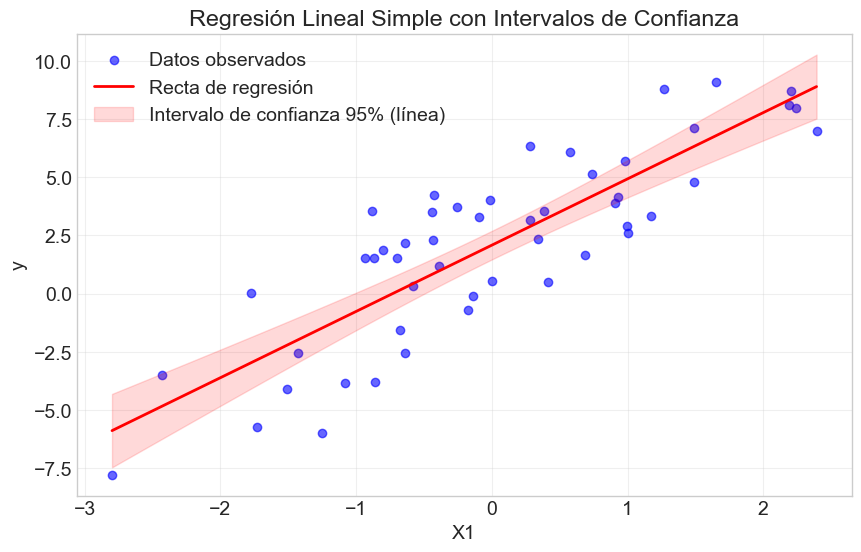

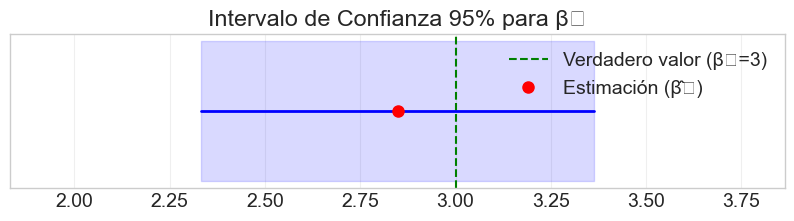

In [6]:
# Visualizar regresión simple
plt.figure(figsize=(10, 6))
plt.scatter(X1, y, color='blue', alpha=0.6, label='Datos observados')

# Valores predichos para la línea de regresión
x_range = np.linspace(min(X1), max(X1), 100)
X_pred = np.column_stack((np.ones(100), x_range))
y_pred = X_pred @ modelo_simple['betas']

plt.plot(x_range, y_pred, color='red', linewidth=2, label='Recta de regresión')

# Intervalos de confianza para la línea de regresión
sigma2 = modelo_simple['sigma2']
se = np.sqrt(np.diag(X_pred @ modelo_simple['var_betas'] @ X_pred.T))
t_crit = stats.t.ppf(0.975, modelo_simple['n'] - modelo_simple['p'] - 1)

plt.fill_between(
    x_range,
    (X_pred @ modelo_simple['betas']).flatten() - t_crit * se,
    (X_pred @ modelo_simple['betas']).flatten() + t_crit * se,
    color='red', alpha=0.15, label='Intervalo de confianza 95% (línea)'
)

plt.title('Regresión Lineal Simple con Intervalos de Confianza')
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualizar el intervalo de confianza para beta1
plt.figure(figsize=(10, 2))
prueba = prueba_t(modelo_simple, 1)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=beta1, color='green', linestyle='--', label='Verdadero valor (β₁=3)')
plt.plot([prueba['ci_lower'], prueba['ci_upper']], [1, 1], 'b-', linewidth=2)
plt.plot(modelo_simple['betas'][1], 1, 'ro', markersize=8, label='Estimación (β̂₁)')
plt.fill_between([prueba['ci_lower'], prueba['ci_upper']], 0.9, 1.1, color='blue', alpha=0.15)
plt.xlim(prueba['ci_lower'] - 0.5, prueba['ci_upper'] + 0.5)
plt.yticks([])
plt.title('Intervalo de Confianza 95% para β₁')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
### 3.2 Ejemplo 2: Regresión Múltiple con Datos Sintéticos


# Generar datos sintéticos para regresión múltiple
np.random.seed(456)
n = 100  # número de observaciones

# Variables independientes
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X3 = np.random.normal(0, 1, n)
X4 = 0.5 * X1 + np.random.normal(0, 0.5, n)  # X4 correlacionada con X1

# Variable dependiente (y = 1 + 2*X1 - 1.5*X2 + 0*X3 + 3*X4 + error)
beta0 = 1    # intercepto
beta1 = 2    # efecto de X1
beta2 = -1.5 # efecto de X2
beta3 = 0    # efecto nulo de X3
beta4 = 3    # efecto de X4
epsilon = np.random.normal(0, 2, n)  # término de error
y = beta0 + beta1 * X1 + beta2 * X2 + beta3 * X3 + beta4 * X4 + epsilon

# Crear matriz de diseño con columna de unos para el intercepto
X = np.column_stack((np.ones(n), X1, X2, X3, X4))

# Ajustar modelo
modelo_multiple = ajustar_ols(X, y)

# Mostrar resultados
nombres_variables = ['Intercepto', 'X1', 'X2', 'X3', 'X4']
tabla_multiple = tabla_resultados(modelo_multiple, nombres_variables)
tabla_multiple


R²: 0.7938
R² ajustado: 0.7851
Estadístico F: 91.4214 (p-valor: 1.11e-16)
Observaciones: 100
Grados de libertad: 95


Variable  Coeficiente  Error Estándar  Estadístico t       p-valor  \
0  Intercepto     1.197349        0.210137       5.697935  1.355904e-07   
1          X1     1.934422        0.302948       6.385321  6.260566e-09   
2          X2    -1.588765        0.186021      -8.540762  2.158274e-13   
3          X3     0.208275        0.206377       1.009197  3.154437e-01   
4          X4     2.667416        0.387687       6.880330  6.330123e-10   

   IC 95.0% Inferior  IC 95.0% Superior Significativo  
0           0.780173           1.614524             *  
1           1.332994           2.535851             *  
2          -1.958065          -1.219466             *  
3          -0.201435           0.617984                
4           1.897759           3.437072             *

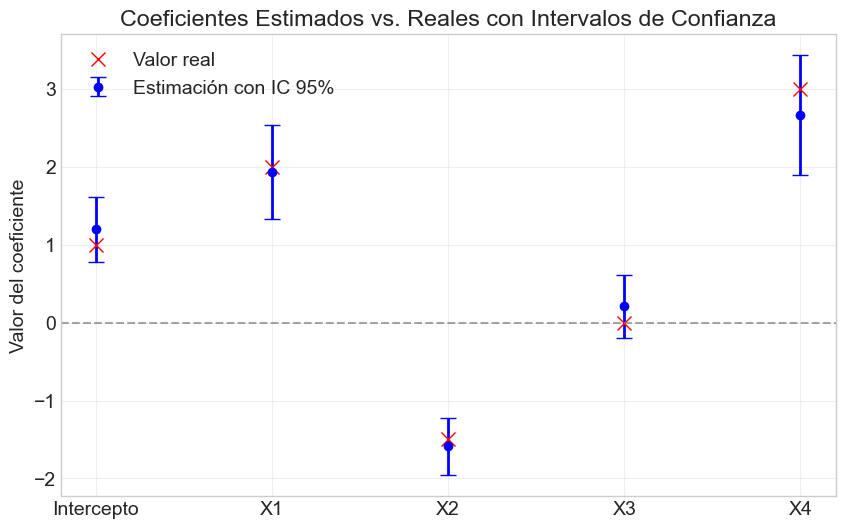

Prueba t para X3:
Coeficiente: 0.2083
Error estándar: 0.2064
Estadístico t: 1.0092
p-valor: 0.3154
Intervalo de confianza 95%: [-0.2014, 0.6180]
Rechazar H0 (α=0.05): [False]


In [8]:
# Visualizar coeficientes estimados con intervalos de confianza
plt.figure(figsize=(10, 6))

# Valores reales de los coeficientes
betas_reales = np.array([beta0, beta1, beta2, beta3, beta4])

# Extraer información del modelo
betas_est = modelo_multiple['betas'].flatten()
se_betas = modelo_multiple['se_betas'].flatten()
n = modelo_multiple['n']
p = modelo_multiple['p']
gl = n - p - 1
t_crit = stats.t.ppf(0.975, gl)

# Calcular intervalos de confianza
ci_lower = betas_est - t_crit * se_betas
ci_upper = betas_est + t_crit * se_betas

# Graficar
for i in range(len(betas_est)):
    plt.errorbar(i, betas_est[i], yerr=t_crit*se_betas[i], fmt='o', color='blue', 
                 ecolor='blue', elinewidth=2, capsize=6, label='Estimación con IC 95%' if i == 0 else "")
    plt.plot(i, betas_reales[i], 'rx', markersize=10, label='Valor real' if i == 0 else "")

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xticks(range(5), nombres_variables)
plt.ylabel('Valor del coeficiente')
plt.title('Coeficientes Estimados vs. Reales con Intervalos de Confianza')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Observemos el p-valor y determinemos si X3 es significativa
prueba_x3 = prueba_t(modelo_multiple, 3)
print(f"Prueba t para X3:")
print(f"Coeficiente: {modelo_multiple['betas'][3][0]:.4f}")
print(f"Error estándar: {modelo_multiple['se_betas'][3][0]:.4f}")
print(f"Estadístico t: {prueba_x3['t_stat']:.4f}")
print(f"p-valor: {prueba_x3['p_value']:.4g}")
print(f"Intervalo de confianza 95%: [{prueba_x3['ci_lower']:.4f}, {prueba_x3['ci_upper']:.4f}]")
print(f"Rechazar H0 (α=0.05): {prueba_x3['rechazar_h0']}")

# Notar que el intervalo de confianza para X3 contiene al cero, lo que concuerda con el verdadero valor


In [9]:
### 3.3 Prueba de Hipótesis Conjunta

# Especificar y ajustar el modelo restringido (sin X3 y X4)
X_restringido = np.column_stack((np.ones(n), X1, X2))
modelo_restringido = ajustar_ols(X_restringido, y)

# Calcular la prueba F para comparar los modelos
q = 2  # número de restricciones (eliminamos X3 y X4)
prueba_f = prueba_f_restricciones(modelo_multiple, modelo_restringido, q)

print(f"Prueba F para restricción conjunta (X3 = X4 = 0):")
print(f"Estadístico F: {prueba_f['f_stat']:.4f}")
print(f"p-valor: {prueba_f['p_value']:.4g}")
print(f"Rechazar H0 (α=0.05): {prueba_f['rechazar_h0']}")

# Mostrar comparación de R² y R² ajustado
print("\nComparación de modelos:")
print(f"Modelo completo - R²: {modelo_multiple['R2']:.4f}, R² ajustado: {modelo_multiple['R2_adj']:.4f}")
print(f"Modelo restringido - R²: {modelo_restringido['R2']:.4f}, R² ajustado: {modelo_restringido['R2_adj']:.4f}")

# Claramente rechazamos la hipótesis nula, lo que significa que X3 y X4 son conjuntamente significativas.
# Esto se debe principalmente al efecto significativo de X4, a pesar de que X3 no es significativa individualmente.


Prueba F para restricción conjunta (X3 = X4 = 0):
Estadístico F: 23.9620
p-valor: 3.753e-09
Rechazar H0 (α=0.05): True

Comparación de modelos:
Modelo completo - R²: 0.7938, R² ajustado: 0.7851
Modelo restringido - R²: 0.6898, R² ajustado: 0.6834


In [10]:
from sklearn.datasets import fetch_california_housing
import numpy as np

# Cargar datos de California Housing directamente
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = housing.feature_names

# Información del dataset
print(f"Conjunto de datos de California Housing cargado.")
print(f"Número de observaciones: {X.shape[0]}")
print(f"Número de predictores: {X.shape[1]}")
print(f"Variables predictoras: {feature_names}")

# Descripción de las variables
print("\nDescripción de las variables:")
variables_descripcion = {
    "MedInc": "Ingreso mediano de los hogares del bloque",
    "HouseAge": "Edad mediana de las viviendas del bloque",
    "AveRooms": "Número promedio de habitaciones por hogar",
    "AveBedrms": "Número promedio de dormitorios por hogar",
    "Population": "Población del bloque",
    "AveOccup": "Número promedio de ocupantes por hogar",
    "Latitude": "Latitud del bloque",
    "Longitude": "Longitud del bloque"
}

for var, desc in variables_descripcion.items():
    print(f"{var}: {desc}")

# Limitar análisis a un subconjunto de datos para mayor claridad
np.random.seed(42)
indices = np.random.choice(range(len(y)), size=500, replace=False)
X = X[indices]
y = y[indices]

# Agregar columna de unos para el intercepto
X_con_intercepto = np.column_stack((np.ones(X.shape[0]), X))

# Ajustar modelo
modelo = ajustar_ols(X_con_intercepto, y)

# Definir nombres de variables para la salida
nombres_variables = ['Intercepto'] + list(feature_names)

# Mostrar resultados
tabla = tabla_resultados(modelo, nombres_variables)
tabla

Conjunto de datos de California Housing cargado.
Número de observaciones: 20640
Número de predictores: 8
Variables predictoras: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Descripción de las variables:
MedInc: Ingreso mediano de los hogares del bloque
HouseAge: Edad mediana de las viviendas del bloque
AveRooms: Número promedio de habitaciones por hogar
AveBedrms: Número promedio de dormitorios por hogar
Population: Población del bloque
AveOccup: Número promedio de ocupantes por hogar
Latitude: Latitud del bloque
Longitude: Longitud del bloque
R²: 0.6924
R² ajustado: 0.6874
Estadístico F: 138.1432 (p-valor: 1.11e-16)
Observaciones: 500
Grados de libertad: 491


Variable  Coeficiente  Error Estándar  Estadístico t   p-valor  \
0  Intercepto   -37.480658        3.761840      -9.963385  0.000000   
1      MedInc     0.372200        0.023036      16.157330  0.000000   
2    HouseAge     0.010385        0.002711       3.831100  0.000144   
3    AveRooms    -0.052616        0.035763      -1.471228  0.141870   
4   AveBedrms     0.775811        0.233978       3.315740  0.000982   
5  Population     0.000070        0.000031       2.246856  0.025093   
6    AveOccup    -0.421594        0.042581      -9.901043  0.000000   
7    Latitude    -0.444628        0.040310     -11.030144  0.000000   
8   Longitude    -0.453540        0.042362     -10.706293  0.000000   

   IC 95.0% Inferior  IC 95.0% Superior Significativo  
0         -44.871949         -30.089368             *  
1           0.326939           0.417461             *  
2           0.005059           0.015711             *  
3          -0.122884           0.017652                
4           0.316089           1.235533             *  
5           0.000009           0.000132             *  
6          -0.505257          -0.337931             *  
7          -0.523830          -0.365426             *  
8          -0.536773          -0.370307             *

Variables significativas (α=0.05):
- Intercepto: p-valor = 0
- MedInc: p-valor = 0
- AveOccup: p-valor = 0
- Latitude: p-valor = 0
- Longitude: p-valor = 0
- HouseAge: p-valor = 0.0001441
- AveBedrms: p-valor = 0.0009817
- Population: p-valor = 0.02509

Variables no significativas (α=0.05):
- AveRooms: p-valor = 0.1419


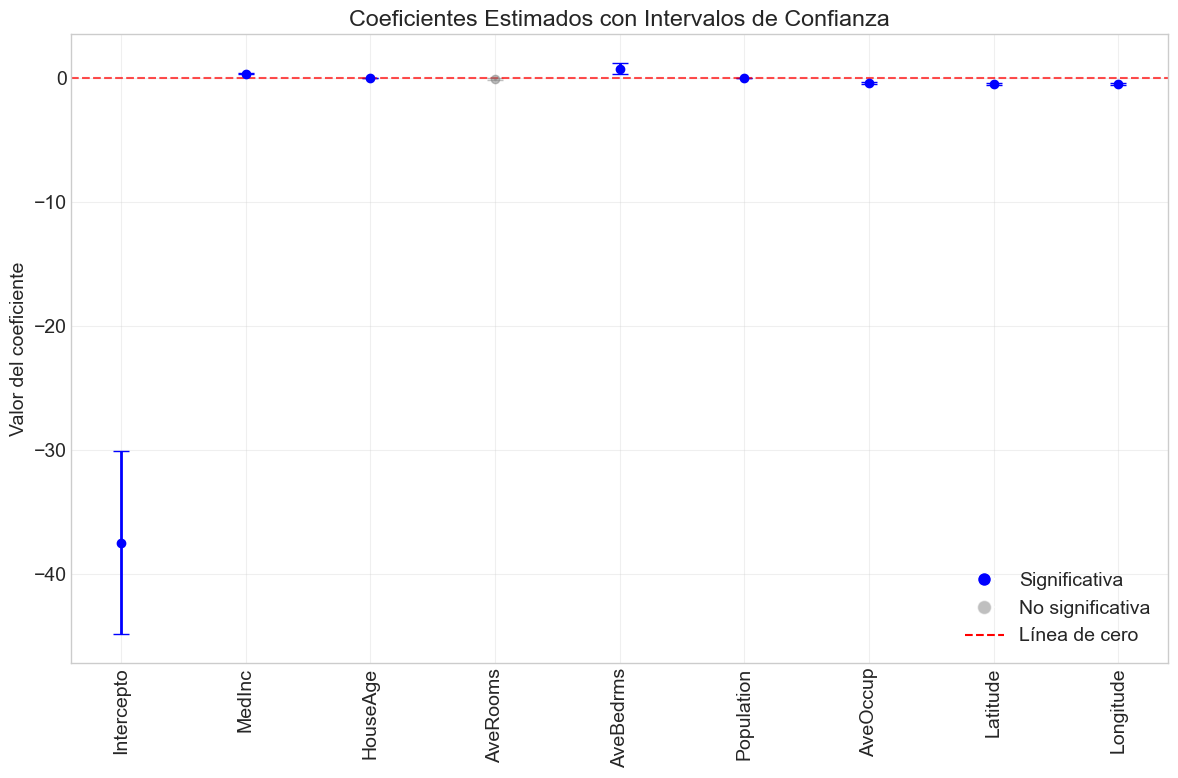


=== GUÍA DE INTERPRETACIÓN DEL GRÁFICO ===
1. Puntos AZULES: Variables estadísticamente significativas (p < 0.05)
2. Puntos GRISES: Variables no significativas (p ≥ 0.05)
3. Línea ROJA PUNTEADA: Referencia de valor cero
4. Barras de error: Intervalos de confianza al 95%
   - Si el intervalo cruza la línea de cero → No hay efecto significativo
   - Si el intervalo está completamente por encima/debajo de cero → Efecto significativo

5. Interpretación de coeficientes:
   - Valor positivo: Por cada unidad que aumenta esta variable, el precio aumenta
   - Valor negativo: Por cada unidad que aumenta esta variable, el precio disminuye
   - Magnitud: Cuanto más lejos de cero, mayor es el efecto de la variable

6. Las variables con intervalos más estrechos tienen estimaciones más precisas

=== ANÁLISIS DE RESULTADOS ===
Variables con mayor impacto positivo:
- AveBedrms: Coeficiente = 0.7758
- MedInc: Coeficiente = 0.3722
- HouseAge: Coeficiente = 0.0104

Variables con mayor impacto negativo:
-

In [11]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# <userStyle>Normal</userStyle>

# Identificar variables significativas
alpha = 0.05
variables_info = []

# Extraer información del modelo
betas_est = modelo['betas'].flatten()
se_betas = modelo['se_betas'].flatten()
n = modelo['n']
p = modelo['p']
gl = n - p - 1
t_crit = stats.t.ppf(0.975, gl)

# Calcular intervalos de confianza
ci_lower = betas_est - t_crit * se_betas
ci_upper = betas_est + t_crit * se_betas

# Calcular significancia para todas las variables de una vez
for i in range(len(nombres_variables)):
    if i == 0:  # Intercepto
        p_val = prueba_t(modelo, i)['p_value']
        es_significativa = prueba_t(modelo, i)['rechazar_h0']
        variables_info.append({
            'nombre': nombres_variables[i],
            'indice': i,
            'p_valor': p_val,
            'significativa': es_significativa,
            'beta': betas_est[i],
            'ci_lower': ci_lower[i],
            'ci_upper': ci_upper[i]
        })
    else:
        p_val = prueba_t(modelo, i)['p_value']
        es_significativa = prueba_t(modelo, i)['rechazar_h0']
        variables_info.append({
            'nombre': nombres_variables[i],
            'indice': i,
            'p_valor': p_val,
            'significativa': es_significativa,
            'beta': betas_est[i],
            'ci_lower': ci_lower[i],
            'ci_upper': ci_upper[i]
        })

# Separar variables significativas y no significativas
variables_significativas = [v for v in variables_info if v['significativa']]
variables_no_significativas = [v for v in variables_info if not v['significativa']]

# Ordenar por p-valor
variables_significativas.sort(key=lambda x: x['p_valor'])
variables_no_significativas.sort(key=lambda x: x['p_valor'])

# Imprimir resultados
print(f"Variables significativas (α={alpha}):")
for var in variables_significativas:
    print(f"- {var['nombre']}: p-valor = {var['p_valor']:.4g}")

print(f"\nVariables no significativas (α={alpha}):")
for var in variables_no_significativas:
    print(f"- {var['nombre']}: p-valor = {var['p_valor']:.4g}")

# Visualizar coeficientes y sus intervalos de confianza
plt.figure(figsize=(12, 8))

# Graficar todas las variables
for var in variables_info:
    color = 'blue' if var['significativa'] else 'gray'
    alpha_val = 1.0 if var['significativa'] else 0.5
    
    plt.errorbar(
        var['indice'], 
        var['beta'], 
        yerr=[[var['beta'] - var['ci_lower']], [var['ci_upper'] - var['beta']]], 
        fmt='o', 
        color=color, 
        ecolor=color, 
        elinewidth=2, 
        capsize=6, 
        alpha=alpha_val
    )

plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xticks(range(len(nombres_variables)), nombres_variables, rotation=90)
plt.ylabel('Valor del coeficiente')
plt.title('Coeficientes Estimados con Intervalos de Confianza')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Añadir leyenda para mejorar interpretación
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Significativa'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', alpha=0.5, markersize=10, label='No significativa'),
    Line2D([0], [0], color='red', linestyle='--', label='Línea de cero')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

# Imprimir guía de interpretación del gráfico
print("\n=== GUÍA DE INTERPRETACIÓN DEL GRÁFICO ===")
print("1. Puntos AZULES: Variables estadísticamente significativas (p < 0.05)")
print("2. Puntos GRISES: Variables no significativas (p ≥ 0.05)")
print("3. Línea ROJA PUNTEADA: Referencia de valor cero")
print("4. Barras de error: Intervalos de confianza al 95%")
print("   - Si el intervalo cruza la línea de cero → No hay efecto significativo")
print("   - Si el intervalo está completamente por encima/debajo de cero → Efecto significativo")
print("\n5. Interpretación de coeficientes:")
print("   - Valor positivo: Por cada unidad que aumenta esta variable, el precio aumenta")
print("   - Valor negativo: Por cada unidad que aumenta esta variable, el precio disminuye")
print("   - Magnitud: Cuanto más lejos de cero, mayor es el efecto de la variable")
print("\n6. Las variables con intervalos más estrechos tienen estimaciones más precisas")

# Añadir análisis específico de los resultados
print("\n=== ANÁLISIS DE RESULTADOS ===")
print("Variables con mayor impacto positivo:")
var_pos = [v for v in variables_significativas if v['beta'] > 0]
for v in sorted(var_pos, key=lambda x: abs(x['beta']), reverse=True)[:3]:
    print(f"- {v['nombre']}: Coeficiente = {v['beta']:.4f}")

print("\nVariables con mayor impacto negativo:")
var_neg = [v for v in variables_significativas if v['beta'] < 0]
for v in sorted(var_neg, key=lambda x: abs(x['beta']), reverse=True)[:3]:
    print(f"- {v['nombre']}: Coeficiente = {v['beta']:.4f}")

## 4. Ejercicios Prácticos

### Ejercicio 1: Regresión Simple
Considere un conjunto de datos con las siguientes observaciones:

```
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Y = [2, 3, 5, 4, 6, 8, 7, 9, 10, 12]
```

a) Ajuste un modelo de regresión simple $Y = \beta_0 + \beta_1 X + \varepsilon$.
b) Calcule e interprete los intervalos de confianza para $\beta_0$ y $\beta_1$.
c) Realice una prueba de hipótesis para determinar si $\beta_1 = 1$ vs $\beta_1 \neq 1$.
d) Visualice la recta de regresión estimada junto con los intervalos de confianza.

### Ejercicio 2: Regresión Múltiple con Datos Simulados
Genere un conjunto de datos con $n=100$ observaciones y $p=4$ predictores, donde solo dos de ellos tienen un efecto real sobre la variable dependiente.

a) Ajuste un modelo de regresión múltiple que incluya todos los predictores.
b) Identifique qué predictores son estadísticamente significativos.
c) Realice una prueba F para determinar si los predictores no significativos pueden excluirse del modelo.
d) Compare el modelo completo con el modelo reducido en términos de $R^2$ y $R^2$ ajustado.

### Ejercicio 3: Análisis de Datos Reales
Utilice el conjunto de datos iris (disponible en scikit-learn) para construir un modelo de regresión que prediga la longitud del pétalo a partir de las demás características.

a) Ajuste un modelo de regresión múltiple.
b) Interprete los coeficientes y su significancia estadística.
c) ¿Qué características son más importantes para predecir la longitud del pétalo?
d) Realice pruebas de hipótesis conjuntas para subconjuntos relevantes de predictores.

### Ejercicio 4: Análisis de Hipótesis y Potencia Estadística
Considere un escenario donde tiene estimaciones con un error estándar relativamente grande.

a) ¿Cómo afecta esto a la probabilidad de cometer errores de Tipo I y Tipo II?
b) Si desea detectar un efecto de tamaño $\delta$, ¿cómo puede calcular el tamaño muestral necesario para alcanzar una potencia estadística de 0.8?
c) Implemente una función para calcular la potencia estadística de una prueba t para un tamaño de efecto dado.

### Ejercicio 5: Desafío de Programación
Implemente una función que permita realizar pruebas de hipótesis sobre combinaciones lineales de coeficientes. Por ejemplo, para probar hipótesis como $H_0: \beta_1 = 2\beta_2$ o $H_0: \beta_1 + \beta_2 + \beta_3 = 0$.


R²: 0.9478
R² ajustado: 0.9413
Estadístico F: 145.2261 (p-valor: 2.076e-06)
Observaciones: 10
Grados de libertad: 8
     Variable  Coeficiente  Error Estándar  Estadístico t   p-valor  \
0  Intercepto     0.933333        0.530485       1.759397  0.116554   
1           X     1.030303        0.085495      12.050980  0.000002   

   IC 95.0% Inferior  IC 95.0% Superior Significativo  
0          -0.289967           2.156634                
1           0.833150           1.227456             *  

Intervalo de confianza 95% para β₀: [-0.2900, 2.1566]
Interpretación: Con 95% de confianza, el valor esperado de Y cuando X=0 está entre -0.2900 y 2.1566.

Intervalo de confianza 95% para β₁: [0.8332, 1.2275]
Interpretación: Con 95% de confianza, el cambio esperado en Y por cada unidad de aumento en X está entre 0.8332 y 1.2275.

Prueba de hipótesis H₀: β₁ = 1 vs H₁: β₁ ≠ 1
Estadístico t: 0.3544
p-valor: 0.7322
Decisión (α=0.05): No rechazar H₀


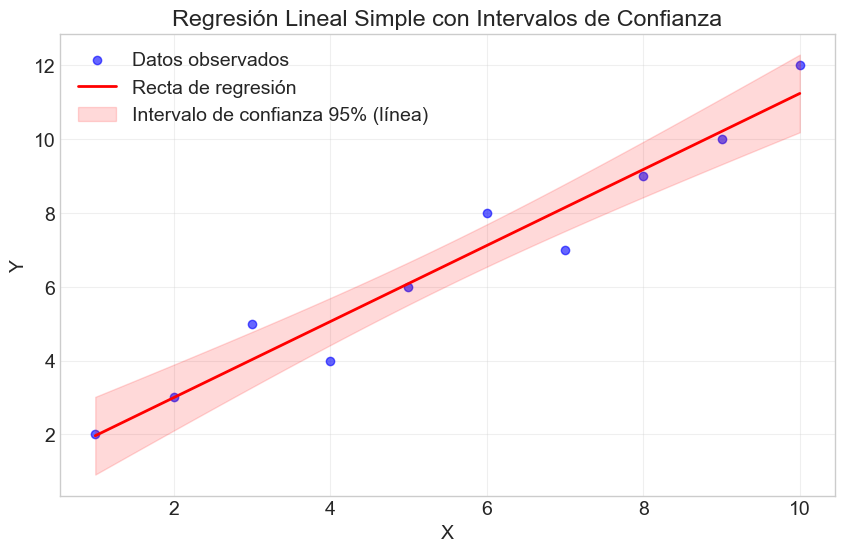

In [12]:
## 5. Soluciones a Ejercicios

### Solución al Ejercicio 1: Regresión Simple

# Datos proporcionados
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Y = np.array([2, 3, 5, 4, 6, 8, 7, 9, 10, 12])

# a) Ajustar modelo de regresión simple
X_design = np.column_stack((np.ones(len(X)), X))
modelo_ej1 = ajustar_ols(X_design, Y)

# Mostrar resultados
nombres_vars = ['Intercepto', 'X']
tabla_ej1 = tabla_resultados(modelo_ej1, nombres_vars)
print(tabla_ej1)

# b) Interpretar intervalos de confianza
prueba_beta0 = prueba_t(modelo_ej1, 0)
prueba_beta1 = prueba_t(modelo_ej1, 1)

print("\nIntervalo de confianza 95% para β₀:", f"[{prueba_beta0['ci_lower']:.4f}, {prueba_beta0['ci_upper']:.4f}]")
print("Interpretación: Con 95% de confianza, el valor esperado de Y cuando X=0 está entre " +
      f"{prueba_beta0['ci_lower']:.4f} y {prueba_beta0['ci_upper']:.4f}.")

print("\nIntervalo de confianza 95% para β₁:", f"[{prueba_beta1['ci_lower']:.4f}, {prueba_beta1['ci_upper']:.4f}]")
print("Interpretación: Con 95% de confianza, el cambio esperado en Y por cada unidad de aumento " +
      f"en X está entre {prueba_beta1['ci_lower']:.4f} y {prueba_beta1['ci_upper']:.4f}.")

# c) Prueba de hipótesis para β₁ = 1
prueba_beta1_1 = prueba_t(modelo_ej1, 1, valor_nulo=1)
print("\nPrueba de hipótesis H₀: β₁ = 1 vs H₁: β₁ ≠ 1")
print(f"Estadístico t: {prueba_beta1_1['t_stat']:.4f}")
print(f"p-valor: {prueba_beta1_1['p_value']:.4g}")
print(f"Decisión (α=0.05): {'Rechazar H₀' if prueba_beta1_1['rechazar_h0'] else 'No rechazar H₀'}")

# d) Visualizar regresión con intervalos de confianza
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color='blue', alpha=0.6, label='Datos observados')

# Valores predichos para la línea de regresión
x_range = np.linspace(min(X), max(X), 100)
X_pred = np.column_stack((np.ones(100), x_range))
y_pred = X_pred @ modelo_ej1['betas']

plt.plot(x_range, y_pred, color='red', linewidth=2, label='Recta de regresión')

# Intervalos de confianza para la línea de regresión
sigma2 = modelo_ej1['sigma2']
se = np.sqrt(np.diag(X_pred @ modelo_ej1['var_betas'] @ X_pred.T))
t_crit = stats.t.ppf(0.975, modelo_ej1['n'] - modelo_ej1['p'] - 1)

plt.fill_between(
    x_range,
    (X_pred @ modelo_ej1['betas']).flatten() - t_crit * se,
    (X_pred @ modelo_ej1['betas']).flatten() + t_crit * se,
    color='red', alpha=0.15, label='Intervalo de confianza 95% (línea)'
)

plt.title('Regresión Lineal Simple con Intervalos de Confianza')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 6. Resumen y Conclusiones

En este taller hemos explorado los principios fundamentales de la inferencia estadística en modelos de regresión lineal. Los puntos clave que hemos abordado son:

1. **Pruebas de hipótesis para coeficientes individuales**: Hemos implementado y aplicado el estadístico t para evaluar la significancia de coeficientes específicos, permitiéndonos determinar qué variables tienen un efecto estadísticamente significativo sobre la variable dependiente.

2. **Intervalos de confianza**: Hemos construido intervalos de confianza para los coeficientes, proporcionando una medida de la incertidumbre asociada a nuestras estimaciones y ofreciendo una forma intuitiva de evaluar la significancia estadística.

3. **Pruebas de hipótesis conjuntas**: Hemos implementado el estadístico F para evaluar si un conjunto de variables es conjuntamente significativo, lo cual es especialmente útil cuando se comparan modelos anidados o se evalúa la significancia global del modelo.

4. **Coeficiente de determinación**: Hemos estudiado el R² y R² ajustado como medidas de la bondad de ajuste del modelo, entendiendo sus limitaciones y su relación con el estadístico F.

Estas herramientas de inferencia estadística son fundamentales en el análisis de regresión, ya que nos permiten:

- Identificar qué variables tienen un efecto real sobre la variable dependiente y cuáles no
- Cuantificar la incertidumbre en nuestras estimaciones
- Comparar modelos alternativos de forma objetiva
- Realizar predicciones con niveles de confianza específicos

En los próximos talleres, abordaremos problemas más avanzados como la multicolinealidad, los diagnósticos de residuos y las extensiones del modelo lineal básico.

### Referencias
- Greene, W. H. (2018). *Econometric Analysis*. Pearson.
- Wooldridge, J. M. (2019). *Introductory Econometrics: A Modern Approach*. Cengage Learning.
- Fox, J. (2015). *Applied Regression Analysis and Generalized Linear Models*. Sage Publications.


## Anexo: Derivación Matemática de la Distribución de los Estimadores

En este anexo, proporcionamos una derivación más detallada de la distribución teórica de los estimadores OLS bajo los supuestos del modelo lineal clásico.

### Distribución del Estimador OLS

Recordemos que el estimador OLS es:

$$\hat{\beta} = (X'X)^{-1}X'y$$

Bajo el modelo $y = X\beta + \varepsilon$ con $\varepsilon \sim N(0, \sigma^2 I_n)$, podemos derivar la distribución de $\hat{\beta}$:

$$\hat{\beta} = (X'X)^{-1}X'(X\beta + \varepsilon) = \beta + (X'X)^{-1}X'\varepsilon$$

Como $\varepsilon \sim N(0, \sigma^2 I_n)$, y $(X'X)^{-1}X'$ es una matriz de constantes (condicional en $X$), tenemos que $\hat{\beta}$ sigue una distribución normal multivariante:

$$\hat{\beta} \sim N(\beta, \sigma^2(X'X)^{-1})$$

### Distribución del Estadístico t

Para un coeficiente individual $\hat{\beta}_j$, podemos estandarizar:

$$\frac{\hat{\beta}_j - \beta_j}{SE(\hat{\beta}_j)} \sim N(0, 1)$$

Sin embargo, dado que utilizamos $\hat{\sigma}^2$ como estimador de $\sigma^2$, la distribución cambia a una t de Student. Esto se debe a que:

$$\frac{(n-p-1)\hat{\sigma}^2}{\sigma^2} \sim \chi^2_{n-p-1}$$

y es independiente de $\hat{\beta}$. Por lo tanto:

$$\frac{\hat{\beta}_j - \beta_j}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j - \beta_j}{\hat{\sigma}\sqrt{[(X'X)^{-1}]_{jj}}} \sim t_{n-p-1}$$

### Distribución del Estadístico F

Para una hipótesis de la forma $H_0: R\beta = r$, el estadístico F se deriva como:

$$F = \frac{(R\hat{\beta} - r)'[R(X'X)^{-1}R']^{-1}(R\hat{\beta} - r)/q}{\hat{\sigma}^2} \sim F_{q, n-p-1}$$

Cuando $r = 0$ y $R$ es una matriz que selecciona un subconjunto de coeficientes, esto se reduce a la prueba F que hemos implementado para comparar modelos anidados.
